In [1]:
import torch
from transformers import AutoModel, AutoTokenizer


roberta_model = AutoModel.from_pretrained("roberta-base")
bert_model = AutoModel.from_pretrained("bert-base-uncased")


roberta_embeddings = roberta_model.embeddings.word_embeddings.weight.detach().numpy()
bert_embeddings = bert_model.embeddings.word_embeddings.weight.detach().numpy()


print("RoBERTa embedding matrix shape:", roberta_embeddings.shape)
print("BERT embedding matrix shape:", bert_embeddings.shape)


roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

roberta_vocab = roberta_tokenizer.get_vocab()
bert_vocab = bert_tokenizer.get_vocab()

print("RoBERTa vocabulary size:", len(roberta_vocab))
print("BERT vocabulary size:", len(bert_vocab))





Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa embedding matrix shape: (50265, 768)
BERT embedding matrix shape: (30522, 768)
RoBERTa vocabulary size: 50265
BERT vocabulary size: 30522


In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
import numpy as np

# Load models and tokenizers
roberta_model = AutoModel.from_pretrained("roberta-base")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

roberta_vocab = roberta_tokenizer.get_vocab()
bert_vocab = bert_tokenizer.get_vocab()


shared_tokens = set(roberta_vocab.keys()) & set(bert_vocab.keys())
print(f"Number of shared tokens: {len(shared_tokens)}")


roberta_embeddings = roberta_model.embeddings.word_embeddings.weight.detach().numpy()
bert_embeddings = bert_model.embeddings.word_embeddings.weight.detach().numpy()

shared_roberta_embeds = []
shared_bert_embeds = []

for token in shared_tokens:
    roberta_idx = roberta_vocab[token]
    bert_idx = bert_vocab[token]
    shared_roberta_embeds.append(roberta_embeddings[roberta_idx])
    shared_bert_embeds.append(bert_embeddings[bert_idx])

shared_roberta_embeds = np.array(shared_roberta_embeds)
shared_bert_embeds = np.array(shared_bert_embeds)


W = np.linalg.lstsq(shared_roberta_embeds, shared_bert_embeds, rcond=None)[0]

print("Shape of transformation matrix W:", W.shape)


transformed_roberta_embeds = np.dot(shared_roberta_embeds, W)


mse = np.mean((transformed_roberta_embeds - shared_bert_embeds)**2)
print("Mean Squared Error:", mse)


from sklearn.metrics.pairwise import cosine_similarity

cos_sims = [cosine_similarity(transformed_roberta_embeds[i].reshape(1, -1), 
                              shared_bert_embeds[i].reshape(1, -1))[0][0] 
            for i in range(len(shared_tokens))]

average_cosine_similarity = np.mean(cos_sims)
print("Average Cosine Similarity:", average_cosine_similarity)

print("\nExamples of transformed embeddings:")
for i, token in enumerate(list(shared_tokens)[:5]):
    print(f"\nToken: {token}")
    print(f"Original RoBERTa embedding: {shared_roberta_embeds[i][:5]}...")
    print(f"Transformed RoBERTa embedding: {transformed_roberta_embeds[i][:5]}...")
    print(f"Original BERT embedding: {shared_bert_embeds[i][:5]}...")
    print(f"Cosine Similarity: {cos_sims[i]}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of shared tokens: 4320
Shape of transformation matrix W: (768, 768)
Mean Squared Error: 0.0008428732
Average Cosine Similarity: 0.77641714

Examples of transformed embeddings:

Token: carry
Original RoBERTa embedding: [ 0.21289062 -0.06433105 -0.25878906  0.02197266  0.0546875 ]...
Transformed RoBERTa embedding: [ 0.03941828 -0.05870258  0.01424392 -0.02408725  0.00039156]...
Original BERT embedding: [ 0.01021518 -0.10299077 -0.01069367 -0.01666609  0.04393836]...
Cosine Similarity: 0.7514048218727112

Token: downs
Original RoBERTa embedding: [-0.03250122  0.13928223 -0.08410645 -0.14123535  0.16564941]...
Transformed RoBERTa embedding: [-0.0579217  -0.07894058 -0.04747115 -0.05570225 -0.04498283]...
Original BERT embedding: [-0.05444201 -0.0918528  -0.054878   -0.03926079 -0.14247154]...
Cosine Similarity: 0.7538611888885498

Token: ram
Original RoBERTa embedding: [ 0.18359375 -0.07531738 -0.09771729  0.17077637  0.05819702]...
Transformed RoBERTa embedding: [ 0.03074608 -0.055

In [17]:
bert_perplexity

2.8336689061067726

In [18]:
roberta_perplexity

1.7287912525688007

In [21]:
def evaluate_model(model, tokenizer, dataset):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for item in tqdm(dataset):
            inputs = tokenizer(item['text'], return_tensors='pt', truncation=True, max_length=512)
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']
            
            
            masked_input = input_ids.clone()
            mask = torch.rand(masked_input.shape) < 0.15 
            masked_input[mask] = tokenizer.mask_token_id
            
            outputs = model(masked_input, attention_mask=attention_mask, labels=input_ids)
            
            
            if isinstance(outputs, tuple):
                loss = outputs[0]
            else:
                loss = outputs.loss
            
            total_loss += loss.item() * input_ids.numel()
            total_tokens += input_ids.numel()
    
    perplexity = math.exp(total_loss / total_tokens)
    return perplexity

In [25]:
import torch
import torch.nn as nn
from transformers import BertModel, RobertaModel, BertTokenizer, BertForMaskedLM

class HybridModel(nn.Module):
    def __init__(self, bert_model, roberta_model, W):
        super(HybridModel, self).__init__()
        self.bert = bert_model.bert  # Use the entire BERT model
        self.roberta_layers = roberta_model.encoder.layer
        self.W = nn.Parameter(torch.tensor(W, dtype=torch.float32))
        self.W_inv = nn.Parameter(torch.tensor(np.linalg.inv(W), dtype=torch.float32))
        
        
        self.cls = bert_model.cls

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        
        bert_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
        
        
        roberta_space = torch.matmul(bert_output, self.W_inv)
        
        
        extended_attention_mask = self.bert.get_extended_attention_mask(attention_mask, input_ids.size(), input_ids.device)
        for layer in self.roberta_layers:
            roberta_space = layer(roberta_space, attention_mask=extended_attention_mask)[0]
        
        
        final_output = torch.matmul(roberta_space, self.W)
        
        
        prediction_scores = self.cls(final_output)
        
        return prediction_scores


bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
roberta_model = RobertaModel.from_pretrained('roberta-base')

hybrid_model = HybridModel(bert_model, roberta_model, W)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text = "The cat sat on the [MASK]."
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = hybrid_model(**inputs)


mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
predicted_token_id = outputs[0, mask_token_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Predicted token: {predicted_token}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted token: ,


/Users/nikxoma/.pyenv/versions/3.10.6/lib/python3.10/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [27]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, RobertaTokenizer, BertForMaskedLM, RobertaForMaskedLM
from datasets import load_dataset
from tqdm import tqdm
import math


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")


subset_size = 1000  
dataset = dataset.select(range(subset_size))


def evaluate_model(model, tokenizer, dataset):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for item in tqdm(dataset):
            inputs = tokenizer(item['text'], return_tensors='pt', truncation=True, max_length=512)
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']
            
            # Create masked input
            masked_input = input_ids.clone()
            mask = torch.rand(masked_input.shape) < 0.15  # 15% masking rate
            masked_input[mask] = tokenizer.mask_token_id
            
            outputs = model(masked_input, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            
            total_loss += loss.item() * input_ids.numel()
            total_tokens += input_ids.numel()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity


bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
roberta_model = RobertaForMaskedLM.from_pretrained('roberta-base')


#bert_perplexity = evaluate_model(bert_model, bert_tokenizer, dataset)

#roberta_perplexity = evaluate_model(roberta_model, roberta_tokenizer, dataset)


hybrid_perplexity = evaluate_model(hybrid_model, bert_tokenizer, dataset)

#print(f"BERT Perplexity: {bert_perplexity:.2f}")
#print(f"RoBERTa Perplexity: {roberta_perplexity:.2f}")
print(f"Hybrid Model Perplexity: {hybrid_perplexity:.2f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Hybrid Model Perplexity: 21076.25


Mean Squared Error: 0.0008428733563050628
Average Cosine Similarity: 0.7764171361923218


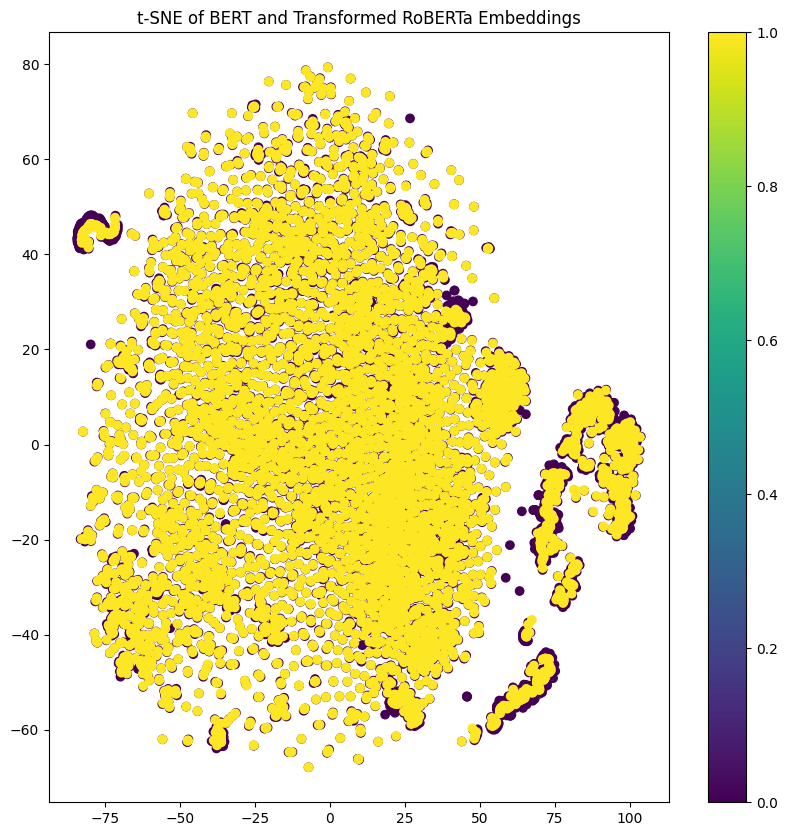

In [34]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


transformed_roberta_embeds = np.dot(shared_roberta_embeds, W)
mse = np.mean((transformed_roberta_embeds - shared_bert_embeds)**2)
print(f"Mean Squared Error: {mse}")


cos_sims = [cosine_similarity(transformed_roberta_embeds[i].reshape(1, -1), 
                              shared_bert_embeds[i].reshape(1, -1))[0][0] 
            for i in range(len(shared_tokens))]

average_cosine_similarity = np.mean(cos_sims)
print(f"Average Cosine Similarity: {average_cosine_similarity}")


def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()


labels = [0] * len(shared_bert_embeds) + [1] * len(transformed_roberta_embeds)


combined_embeddings = np.vstack((shared_bert_embeds, transformed_roberta_embeds))


plot_embeddings(combined_embeddings, labels, "t-SNE of BERT and Transformed RoBERTa Embeddings")


In [35]:
import torch
import torch.nn as nn
from transformers import BertModel, RobertaModel, BertTokenizer, BertForMaskedLM, AutoModel
import numpy as np


W_tensor = torch.tensor(W, dtype=torch.float32)
W_inv_tensor = torch.tensor(W_inv, dtype=torch.float32)

class HybridModel(nn.Module):
    def __init__(self, bert_model, roberta_model, W, W_inv):
        super(HybridModel, self).__init__()
        self.bert = bert_model.bert  # Use the entire BERT model
        self.roberta_layers = roberta_model.encoder.layer
        self.W = nn.Parameter(W, requires_grad=False)
        self.W_inv = nn.Parameter(W_inv, requires_grad=False)
        
        
        self.cls = bert_model.cls

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        
        bert_output = self.bert.embeddings(input_ids, token_type_ids=token_type_ids)
        extended_attention_mask = self.bert.get_extended_attention_mask(attention_mask, input_ids.size(), input_ids.device)
        
        for layer in self.bert.encoder.layer:
            bert_output = layer(bert_output, extended_attention_mask)[0]
        
        
        roberta_space = torch.matmul(bert_output, self.W_inv)
        
        
        for layer in self.roberta_layers:
            roberta_space = layer(roberta_space, attention_mask=extended_attention_mask)[0]
        
        
        final_output = torch.matmul(roberta_space, self.W)
        
        
        prediction_scores = self.cls(final_output)
        
        return prediction_scores


bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
roberta_model = RobertaModel.from_pretrained('roberta-base')


hybrid_model = HybridModel(bert_model, roberta_model, W_tensor, W_inv_tensor)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text = "The cat sat on the [MASK]."
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = hybrid_model(**inputs)

# Get the predicted token
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
predicted_token_id = outputs[0, mask_token_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Predicted token: {predicted_token}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted token: ,


/Users/nikxoma/.pyenv/versions/3.10.6/lib/python3.10/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [39]:
import torch
import torch.nn as nn
from transformers import BertModel, RobertaModel, BertTokenizer, BertForMaskedLM, RobertaForMaskedLM
import numpy as np


W_tensor = torch.tensor(W, dtype=torch.float32)
W_inv_tensor = torch.tensor(W_inv, dtype=torch.float32)

class HybridModel(nn.Module):
    def __init__(self, bert_model, roberta_model, W, W_inv):
        super(HybridModel, self).__init__()
        self.bert = bert_model.bert  # Use the entire BERT model
        self.roberta_layers = roberta_model.roberta.encoder.layer  # Correctly access RoBERTa encoder layers
        self.W = nn.Parameter(W, requires_grad=False)
        self.W_inv = nn.Parameter(W_inv, requires_grad=False)
        
        
        self.cls = bert_model.cls

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        
        bert_output = self.bert.embeddings(input_ids, token_type_ids=token_type_ids)
        extended_attention_mask = self.bert.get_extended_attention_mask(attention_mask, input_ids.size(), input_ids.device)
        
        for layer in self.bert.encoder.layer:
            bert_output = layer(bert_output, extended_attention_mask)[0]
        
        
        roberta_space = torch.matmul(bert_output, self.W_inv)
        
        
        for layer in self.roberta_layers:
            roberta_space = layer(roberta_space, attention_mask=extended_attention_mask)[0]
        
        
        final_output = torch.matmul(roberta_space, self.W)
        
        
        prediction_scores = self.cls(final_output)
        
        return prediction_scores

    def compute_loss(self, prediction_scores, labels, attention_mask):
        
        shift_logits = prediction_scores[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask = attention_mask[..., 1:].contiguous()
        
        
        loss_fct = nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        
        loss = loss * shift_attention_mask.view(-1)
        return loss.sum() / shift_attention_mask.sum()


bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
roberta_model = RobertaForMaskedLM.from_pretrained('roberta-base')


hybrid_model = HybridModel(bert_model, roberta_model, W_tensor, W_inv_tensor)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
import torch
from transformers import BertTokenizer, RobertaTokenizer, BertForMaskedLM, RobertaForMaskedLM
from datasets import load_dataset
from tqdm import tqdm
import math

# Load tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load the dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

# Limit to a subset for quicker evaluation
subset_size = 1000  # Adjust this value as needed
dataset = dataset.select(range(subset_size))

# Evaluation function
def evaluate_model(model, tokenizer, dataset):
    model.eval()
    total_loss = 0
    total_tokens = 0
    loss_fct = nn.CrossEntropyLoss()

    with torch.no_grad():
        for item in tqdm(dataset):
            inputs = tokenizer(item['text'], return_tensors='pt', truncation=True, max_length=512)
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']
            
            # Create masked input
            masked_input = input_ids.clone()
            mask = torch.rand(masked_input.shape) < 0.15  # 15% masking rate
            masked_input[mask] = tokenizer.mask_token_id
            
            
            prediction_scores = model(masked_input, attention_mask=attention_mask)
            
            
            shift_logits = prediction_scores[..., :-1, :].contiguous()
            shift_labels = input_ids[..., 1:].contiguous()
            
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            
            total_loss += loss.item() * input_ids.numel()
            total_tokens += input_ids.numel()

    perplexity = math.exp(total_loss / total_tokens)
    return perplexity


bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
roberta_model = RobertaForMaskedLM.from_pretrained('roberta-base')


hybrid_model = HybridModel(bert_model, roberta_model, W_tensor, W_inv_tensor)


print("Evaluating Hybrid Model...")
hybrid_perplexity = evaluate_model(hybrid_model, bert_tokenizer, dataset)

print(f"Hybrid Model Perplexity: {hybrid_perplexity:.2f}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating Hybrid Model...


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/nikxoma/.pyenv/versions/3.10.6/lib/python3.10/site-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]

Hybrid Model Perplexity: 20680.85
